In [16]:
!pip install pmdarima

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import root_mean_squared_error
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("ignore", message=".*no associated frequency information.*")
#warnings.filterwarnings("ignore", message=".*Non-stationary starting.*")
#warnings.filterwarnings("ignore", message=".*Non-invertible starting.*")

In [18]:
csv_url="https://raw.githubusercontent.com/anshsaboo/nvidia-stock-forecast/refs/heads/data/nvidia_stock_cleaned.csv"
df=pd.read_csv(csv_url)

In [19]:
df.head(10)

,date,open,high,low,close,adjclose,volume
0,2015-01-02,0.50325,0.50700,0.49525,0.50325,0.483218,113680000
1,2015-01-05,0.50325,0.50475,0.49250,0.49475,0.475056,197952000
2,2015-01-06,0.49550,0.49600,0.47925,0.47975,0.460654,197764000
3,2015-01-07,0.48325,0.48750,0.47700,0.47850,0.459453,321808000
4,2015-01-08,0.48400,0.49950,0.48375,0.49650,0.476737,283780000
5,2015-01-09,0.49825,0.50225,0.49150,0.49850,0.478657,209540000
6,2015-01-12,0.49975,0.50000,0.48775,0.49225,0.472656,190732000
7,2015-01-13,0.49600,0.50600,0.48800,0.49150,0.471936,236720000
8,2015-01-14,0.48625,0.49500,0.48500,0.49350,0.473856,155260000
9,2015-01-15,0.49700,0.50000,0.48975,0.49000,0.470496,188932000


In [20]:
df.tail(10)


,date,open,high,low,close,adjclose,volume
2359,2024-05-17,94.369003,94.739998,91.806000,92.478996,92.471397,359691000
2360,2024-05-20,93.750000,95.199997,93.440002,94.779999,94.772217,318764000
2361,2024-05-21,93.598999,95.400002,93.180000,95.386002,95.378166,328946000
2362,2024-05-22,95.459000,96.019997,93.249001,94.949997,94.942200,548648000
2363,2024-05-23,102.028000,106.320000,101.519997,103.799004,103.790482,835065000
2364,2024-05-24,104.448997,106.474998,103.000000,106.469002,106.460258,429494000
2365,2024-05-28,110.244003,114.939003,109.883003,113.901001,113.891647,652728000
2366,2024-05-29,113.050003,115.491997,110.901001,114.824997,114.815567,557442000
2367,2024-05-30,114.650002,115.819000,109.663002,110.500000,110.490921,487350000
2368,2024-05-31,112.519997,112.717003,106.940002,109.633003,109.624001,613263000


In [21]:
df['date']=pd.to_datetime(df['date'])
df.set_index('date',inplace=True)
df = df.asfreq(df.index.inferred_freq or 'B')

In [22]:
df=df[['close']].dropna()

In [23]:
df.index=pd.DatetimeIndex(df.index)
df.index.freq=df.index.inferred_freq

In [24]:
ts=df['close']

In [25]:
train_size=int(len(ts)*0.8)
train=ts[:train_size]
test=ts[train_size:]


In [26]:
train.index = pd.DatetimeIndex(train.index)
train.index.freq = train.index.inferred_freq

In [27]:
auto_model=auto_arima(train,seasonal=False,stepwise=True,suppress_warnings=True)
p,d,q=auto_model.order
print(f"Best ARIMA order: (p={p}, d={d}, q={q})")
model=ARIMA(train,order=(p,d,q))
fitted_model=model.fit()
    


Best ARIMA order: (p=2, d=1, q=1)


In [28]:
forecast = fitted_model.forecast(steps=len(test))
forecast_series = pd.Series(forecast, index=test.index)


In [29]:
mae = mean_absolute_error(test, forecast)
rmse = root_mean_squared_error(test,forecast)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 26.20
RMSE: 35.96


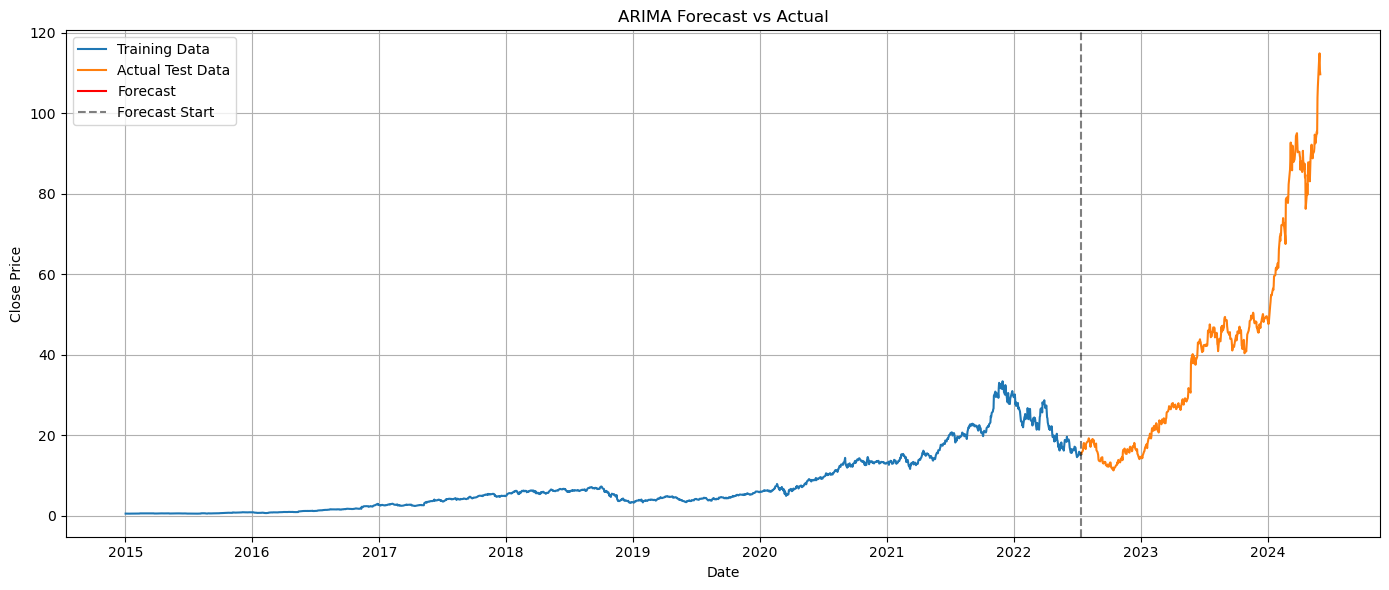

In [30]:
plt.figure(figsize=(14, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Test Data')
plt.plot(forecast_series, label='Forecast', color='red')
plt.axvline(test.index[0], color='black', linestyle='--', alpha=0.5, label='Forecast Start')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
final_model=ARIMA(ts,order=(p,d,q))
final_fit=final_model.fit()
future_steps=180

In [32]:
future_forecast=final_fit.get_forecast(steps=future_steps)
future_mean=future_forecast.predicted_mean
conf_int=future_forecast.conf_int()


In [33]:
last_date = ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='B')

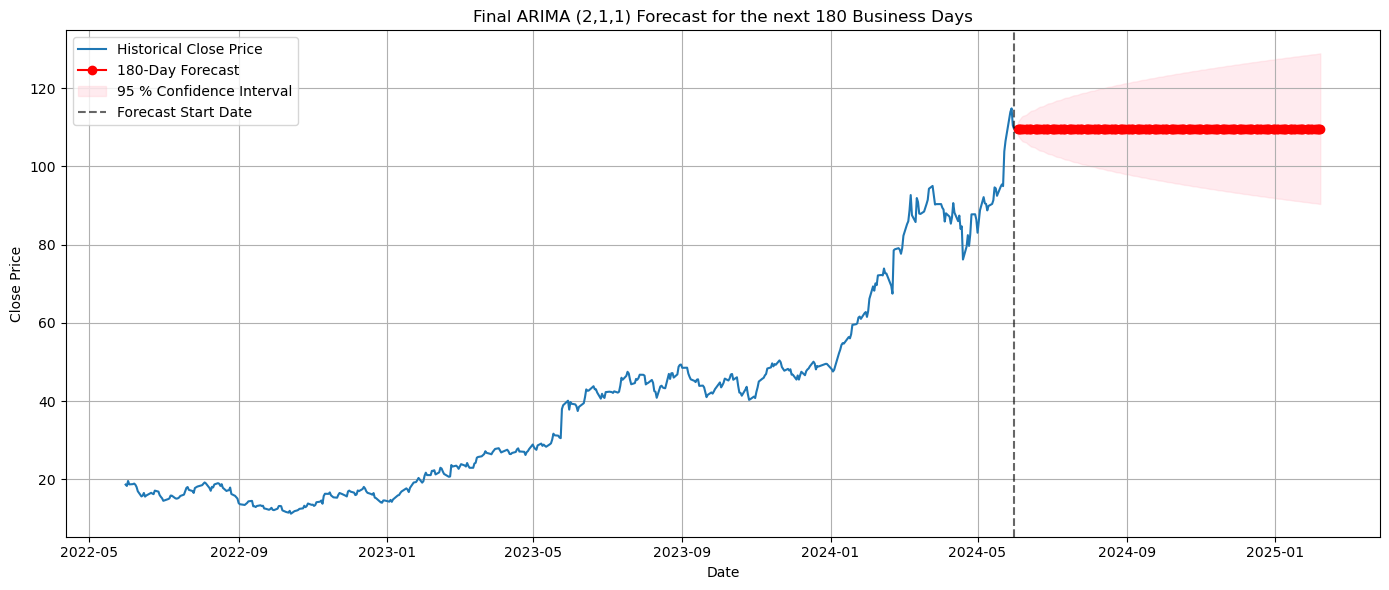

In [34]:
plt.figure(figsize=(14,6))
recent_data = ts[ts.index >= ts.index[-252*2]]  # roughly last 2 years of business days
plt.plot(recent_data, label="Historical Close Price")
plt.plot(future_dates,future_mean,label='180-Day Forecast',color='red',marker='o',linestyle='solid')
plt.fill_between(future_dates,conf_int.iloc[:,0],conf_int.iloc[:,1],color='pink',alpha=0.3,label='95 % Confidence Interval')
plt.axvline(x=last_date,color='black',linestyle='--',alpha=0.6,label='Forecast Start Date')
plt.title(f"Final ARIMA ({p},{d},{q}) Forecast for the next 180 Business Days")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()